In [8]:
import pandas as pd
import pickle
from matplotlib.transforms import Bbox
from correlation_functions import plot_correlation_boxplots,plot_numerical_correlations
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,to_rgb
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib import colormaps
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cd45_color = '#F8766D'
ck_color = '#00BA38'
cd68_color = '#619CFF'

patient_colors = {
#        'patient 1': '#999999',  # Gray
        'patient 2': '#E69F00',  # Orange
        'patient 4': '#56B4E9',  # Sky Blue
        'patient 5': '#009E73',  # Bluish Green
        'patient 6': '#F0E442',  # Yellow
        'patient 7': '#0072B2',  # Blue
        'patient 8': '#D55E00',  # Vermillion
        'patient 9': '#CC79A7',  # Reddish Purple
        #'patient 10': '#000000', # Black
        'patient 11': '#654321', # Dark Brown
#        'patient 12': '#9400D3'  # Violet
        }
mucinous_colors = {"mucinous":"#A6CEE3","non-mucinous":"#FDBF6F"}
location_colors = {'border':'#00BA38',
                   'intra-tumor':'#B79F00',
                   'extra-tumor':'#00BFC4'}

metastasis_location_colors = {
        "cutaneous": "#E6194B",    # Bright red
        "liver": "#3CB44B",        # Green
        "pancreas": "#4363D8",     # Blue
        "peritoneum/gastric wall": "#F58231",  # Orange
        "node": "#911EB4",         # Purple
        "peritoneum": "#42D4F4"    # Cyan
        }
momac_colors = {
        "C1Q Macrophage"        : "#8326f9",
        "CD16- Monocytes -12"       : "#2900f6",
        "CD16- Monocytes -8"        :  "#11006b",
        "CD16+ Monocytes -1"        : "#24460a",
        "CD16+ Monocytes -5"        : "#519f17",
        "DC2/DC3"               : "#99a01f",
        "FTL Macrophage"        : "#c098f8",
        "HES1 Macrophage"        : "#e7ba79",
        "IL1B Monocytes"        : "#648df9",
        "IL4I1 Macrophage"       : "#d100fa",
        "ISG Monocytes"          : "#84ff2a",
        "Macrophage -11"            : "#000000",
        "Macrophage -13"            : "#878787",
        "Macrophage -7"             : "#810099",
        "Proliferating cells"   : "#8bfdfd",
        "Tcell Doublets"         : "#7d0a45",
        "TREM2 Macrophage"       : "#cb181b"
        }
primitive_metastasis_colors = {
        "primitive":"#00BFC4",
        "metastasis":"#F8766D"
        }
tumoral_col = "#A0D5C7"
stromal_col = "#56B4E9"
no_cd68_col = "#E69F00"
adjacent_col = "#999999"
intra_col = "#F8A40D"
extra_col = "#A88E7C"
low = "#83AF9B"
mid = "#F9CDAD"
high = "#FE4365"

def get_palette(hex_color):
    end_color_rgb = mcolors.hex2color(hex_color)
    # Create color map
    colors = [(1, 1, 1), end_color_rgb]  # White to end_color
    n_bins = [0, 1]  # List of positions for the colors
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", list(zip(n_bins, colors)), N=10)
    return cmap

def cascade_sort(df, threshold=0.75):
    # Create a copy of the dataframe to avoid modifying the original
    sorted_df = df.copy()
    # Get the number of rows and columns
    n_rows, n_cols = sorted_df.shape
    # Initialize an array to keep track of already placed rows
    placed_rows = np.zeros(n_rows, dtype=bool)
    # Initialize the new index
    new_index = []
    for col in sorted_df.columns:
        # Get the values of the current column
        values = sorted_df[col].values
        # Calculate the threshold value for this column
        threshold_value = np.quantile(values, threshold)
        # Find the indices of values above the threshold that haven't been placed yet
        high_value_indices = np.where((values > threshold_value) & ~placed_rows)[0]
        # Sort these indices by their values in descending order
        high_value_indices = high_value_indices[np.argsort(-values[high_value_indices])]
        # Add these indices to the new index and mark them as placed
        new_index.extend(high_value_indices)
        placed_rows[high_value_indices] = True
    # Add any remaining unplaced rows to the end
    remaining_rows = np.where(~placed_rows)[0]
    new_index.extend(remaining_rows)
    # Return the dataframe with the new row order
    return sorted_df.iloc[new_index]

# Create a function to map values to categories
def get_category(value,dic):
    for key, values in dic.items():
        if value in values:
            return key

def flatten(lst):
    for item in lst:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

metadata = pd.read_excel("annotations_with_proximity_score.xlsx",index_col=0)

In [10]:
metadata.index

Index(['DSP-1001660005664-D-C02', 'DSP-1001660005664-D-C03',
       'DSP-1001660005664-D-C04', 'DSP-1001660005664-D-C05',
       'DSP-1001660005664-D-C06', 'DSP-1001660005664-D-C07',
       'DSP-1001660005664-D-C08', 'DSP-1001660005664-D-C09',
       'DSP-1001660005664-D-D04', 'DSP-1001660005664-D-D05',
       ...
       'DSP-1001660005664-D-A06', 'DSP-1001660005664-D-A07',
       'DSP-1001660005664-D-A08', 'DSP-1001660005664-D-A09',
       'DSP-1001660005664-D-A10', 'DSP-1001660005664-D-A11',
       'DSP-1001660005664-D-A12', 'DSP-1001660005664-D-B01',
       'DSP-1001660005664-D-B02', 'DSP-1001660005664-D-B03'],
      dtype='object', name='Sample_ID', length=253)

In [12]:
metadata['patient_id'] = metadata['patient_id'].replace(
        {
            "pancreas_patient_11":"patient 11",
            "pancreas_patient_2":"patient 2",
            "pancreas_patient_4":"patient 4",
            "pancreas_patient_5":"patient 5",
            "pancreas_patient_6":"patient 6",
            "pancreas_patient_7":"patient 7",
            "pancreas_patient_8":"patient 8",
            "pancreas_patient_9":"patient 9"
            }
        )

metadata['metastasis_location'] = metadata['metastasis_location'].fillna('pancreas')
metadata['location'] = metadata['location'].replace({"tsip":"intra-tumor"})

normalized_expression = pd.read_csv("geomx_normalized_counts.csv",index_col=0)
normalized_expression.columns = normalized_expression.columns.str.replace('.dcc$', '', regex=True)
cd68_deconvolution_results = pd.read_csv('cd68_momac_deconvoluted.csv',index_col=0)
cd68_deconvolution_results.rename(columns = {"C1Q Macrophage -16": "C1Q Macrophage", "DC2/DC3 -14": "DC2/DC3", "FTL Macrophage -17": "FTL Macrophage", "HES1 Macrophage -2": "HES1 Macrophage", "IL1B Monocytes -15": "IL1B Monocytes", "IL4I1 Macrophage -6": "IL4I1 Macrophage", "ISG Monocytes -4": "ISG Monocytes", "Proliferating cells -10": "Proliferating cells", "Tcell Doublets -9": "Tcell Doublets", "TREM2 Macrophage -3": "TREM2 Macrophage"},inplace = True)
cd68_deconvolution_results.index = cd68_deconvolution_results.index.str.replace('.dcc$', '', regex=True)
cd68_segments = cd68_deconvolution_results.index.tolist()
metadata = metadata.loc[(metadata.index.isin(cd68_segments)) ] # Subset the metadata to only CD68 segments
#metadata = metadata.loc[(metadata['Sample_ID'].isin(cd68_segments)) & ( metadata['primitive_metastasis'] == 'primitive')] # Subset the metadata to only CD68 segments
#metadata = metadata.dropna(subset=['ck_score', 'cd45_score'])

nan_subset = metadata[metadata['ck_score'].isna() & metadata['cd45_score'].isna()]

normalized_expression= normalized_expression[[x for x in cd68_segments if x in normalized_expression.columns]]

common_samples = normalized_expression.columns.tolist()
metadata = metadata.loc[metadata.index.isin(common_samples)]

cd68_deconvolution_results = cd68_deconvolution_results.loc[cd68_deconvolution_results.index.isin(common_samples)]

# metadata = metadata.set_index('Sample_ID')

cd68_deconvolution_results = cd68_deconvolution_results.join(metadata[["metastasis_location","location","patient_id","primitive_metastasis","ck_score","cd45_score"]], how='inner')

samples_ordered = cd68_deconvolution_results.sort_values(by=['primitive_metastasis','IL1B Monocytes'], ascending=True).index.tolist()
cd68_deconvolution_results = cd68_deconvolution_results.loc[samples_ordered]

# Extract the column, make the IL1B stack on top
il1b_columns = cd68_deconvolution_results.pop('IL1B Monocytes')
# Insert at position 6 (will be 7th column since Python is 0-indexed)
cd68_deconvolution_results.insert(16, 'IL1B Monocytes', il1b_columns)
###################### SUBTYPE PLOTS ###############################

def create_heatmap_subplot(ax, data_series, cmap_str=None, cat=False, cat_color_dict=None):
    """
    Create a heatmap subplot similar to ax1.

    :param ax: matplotlib axis object to plot on
    :param data_series: pandas Series containing the data to plot
    :param cmap_str: string name of the colormap to use (for non-categorical data)
    :param cat: boolean indicating if the data is categorical
    :param cat_color_dict: dictionary mapping categories to hex colors (for categorical data)
    :return: matplotlib image object
    """
    if not cat:
        cmap = get_palette(cmap_str)
        norm = plt.Normalize(vmin=data_series.min(), vmax=data_series.max())
        im = ax.imshow(data_series.values.reshape(1, -1), aspect='auto', cmap=cmap, norm=norm,
                       extent=[0, len(data_series), 0, 1])
    else:
        if cat_color_dict is None:
            raise ValueError("For categorical data, please provide a cat_color_dict")

        # Get unique categories
        categories = cat_color_dict.keys()

        # Create a ListedColormap with colors from the dictionary
        colors = [to_rgb(cat_color_dict[cat]) for cat in categories]
        custom_cmap = ListedColormap(colors)

        # Create a mapping of categories to integers
        cat_to_int = {cat: i for i, cat in enumerate(categories)}

        # Convert categorical data_series to integer data_series
        int_data_series = data_series.map(cat_to_int)

        # Plot the heatmap
        im = ax.imshow(int_data_series.values.reshape(1, -1), aspect='auto', cmap=custom_cmap,
                       extent=[0, len(data_series), 0, 1], vmin=-0.5, vmax=len(categories) - 0.5)

        # Create legend handles
        legend_elements = [Patch(facecolor=cat_color_dict[cat], edgecolor='black', label=cat) for cat in categories]
        # Add legend to the axis
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5),
                  ncol=2, columnspacing=1, handletextpad=0.5, fontsize=8)

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.tick_params(axis='x', which='both', length=0)
    plt.setp(ax.get_xticklabels(), visible=False)

    for spine in ax.spines.values():
        spine.set_visible(False)
    return im

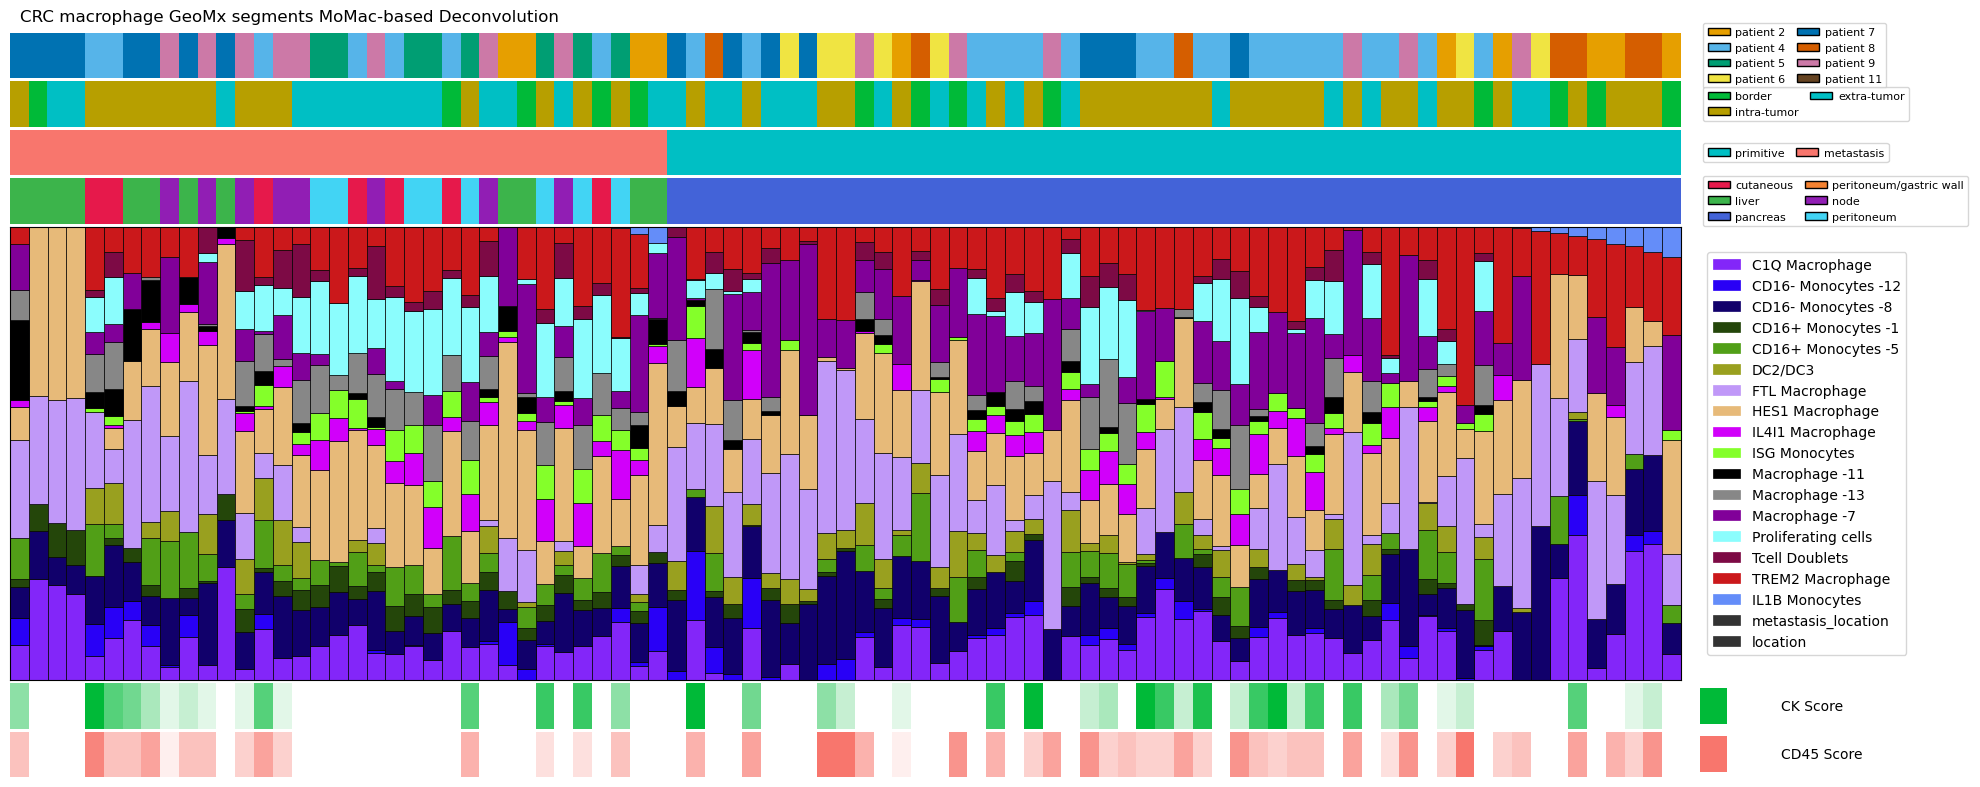

In [13]:
###################################################################################
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(7, 3, figure=fig, width_ratios=[1, 0.03, 0.12], height_ratios=[0.1,
                                                                             0.1,
                                                                             0.1,
                                                                             0.1,
                                                                             1,
                                                                             0.1,
                                                                             0.1
                                                                             ], hspace=0.03, wspace=0.03)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0]) # patient
ax2 = fig.add_subplot(gs[1, 0]) # location
ax3 = fig.add_subplot(gs[2, 0]) # primitive metastasis
ax4 = fig.add_subplot(gs[3, 0]) # metastasis location

ax5 = fig.add_subplot(gs[4, 0]) # deconvolution stacked barplot

ax6 = fig.add_subplot(gs[5, 0]) # ck score
ax7 = fig.add_subplot(gs[6, 0]) # cd45 score

patients = cd68_deconvolution_results['patient_id']
im1 = create_heatmap_subplot(ax1, patients, cat = True, cat_color_dict=patient_colors)

location = cd68_deconvolution_results['location'].loc[samples_ordered]
im2 = create_heatmap_subplot(ax2, location, cat = True,cat_color_dict=location_colors)

primitive_metastasis = cd68_deconvolution_results['primitive_metastasis']
im3 = create_heatmap_subplot(ax3, primitive_metastasis, cat = True,cat_color_dict=primitive_metastasis_colors)

metastasis_location = cd68_deconvolution_results['metastasis_location']
im4 = create_heatmap_subplot(ax4, metastasis_location, cat = True,cat_color_dict=metastasis_location_colors)
#legend_ax4 = ax4.legend(ncol=2, loc='upper right')

########### stacked barplot ############
bars = cd68_deconvolution_results.plot( kind='bar', stacked=True, edgecolor='black', linewidth=0.5, ax=ax5, width=1, color=[momac_colors.get(x, '#333333') for x in cd68_deconvolution_results.columns] )
########################################

ck_score = cd68_deconvolution_results['ck_score']
im6 = create_heatmap_subplot(ax6, ck_score, cat = False, cmap_str = ck_color)

cd45_score = cd68_deconvolution_results['cd45_score']
im7 = create_heatmap_subplot(ax7, cd45_score, cat = False, cmap_str = cd45_color)

# Create horizontal colorbar for ax5 (CD68 score)
legend_ax6 = fig.add_subplot(gs[5, 1:])
legend_ax6.axis('off')
rect6 = patches.Rectangle((0, 0.10), 0.1, 0.8, facecolor=ck_color)  # Adjust color as needed
legend_ax6.add_patch(rect6)
legend_ax6.text(0.3, 0.5, 'CK Score', va='center', ha='left')

# Create horizontal colorbar for ax6 (CD45 score)
legend_ax7 = fig.add_subplot(gs[6, 1:])
legend_ax7.axis('off')
rect7 = patches.Rectangle((0, 0.1), 0.1, 0.8, facecolor=cd45_color)  # Adjust color as needed
legend_ax7.add_patch(rect7)
legend_ax7.text(0.3, 0.5, 'CD45 Score', va='center', ha='left')

for spine in ax5.spines.values():
    spine.set_visible(True)

ax5.tick_params(axis='x', which='both', length=0)
ax5.set_yticks([])
ax5.set_xticklabels([])

# Align subplots
ax5.set_xlim(-0.5, len(samples_ordered) - 0.5)
ax5.set_ylim(0, 0.9)

# Create legend handles and labels
legend_ax = fig.add_subplot(gs[4, 1])
handles = [plt.Rectangle((0,0),1,1, color=container.patches[0].get_facecolor(), linewidth=0.5) for container in bars.containers]
labels = cd68_deconvolution_results.columns

# Remove the legend from ax4
ax5.get_legend().remove()
# Add the legend to the legend axis
legend_ax.legend(handles, labels, loc='center left')
legend_ax.axis('off')

# Adjust the position of subplots to remove any remaining whitespace
fig.suptitle('CRC macrophage GeoMx segments MoMac-based Deconvolution' , x=0.015, horizontalalignment='left', fontsize=12)
fig.subplots_adjust(top=0.95, bottom=0.02, left=0.01, right=0.99)
plt.show()

/home/dimitris/Workspace/miniconda/envs/sc_analysis/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dimitris/Workspace/miniconda/envs/sc_analysis/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dimitris/Workspace/miniconda/envs/sc_analysis/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 24.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dimitris/Workspace/miniconda/envs/sc_analysis/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or u

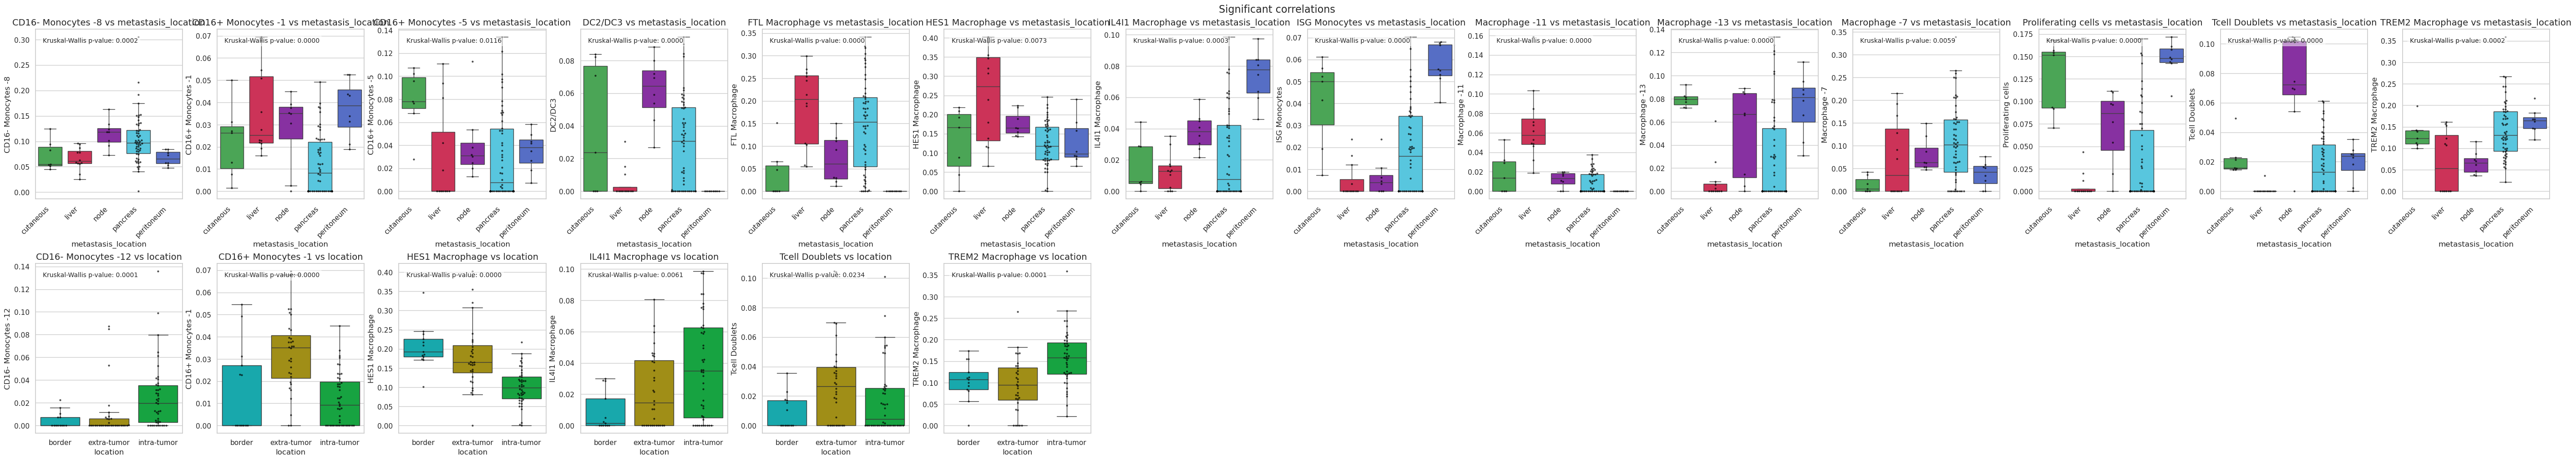

In [17]:
cd68_deconvolution_results['patients'] = patients
cd68_deconvolution_results['location'] = location
cd68_deconvolution_results['metastasis_location'] = metastasis_location

macrophage_subtypes =["C1Q Macrophage", "CD16- Monocytes -12", "CD16- Monocytes -8", "CD16+ Monocytes -1", "CD16+ Monocytes -5", "DC2/DC3", "FTL Macrophage", "HES1 Macrophage", "IL1B Monocytes", "IL4I1 Macrophage", "ISG Monocytes", "Macrophage -11", "Macrophage -13", "Macrophage -7", "Proliferating cells", "Tcell Doublets", "TREM2 Macrophage"]

plot_correlation_boxplots(cd68_deconvolution_results,
                          categorical_columns = ['metastasis_location','location'],
                          numerical_columns = macrophage_subtypes, test = 'kruskal',
                          color_dicts = [metastasis_location_colors,location_colors],
                          title = "Significant correlations")


Correlation of C1Q Macrophage
Correlation of CD16- Monocytes -12
Correlation of CD16- Monocytes -8
Correlation of CD16+ Monocytes -1
Correlation of CD16+ Monocytes -5
Correlation of DC2/DC3
Correlation of FTL Macrophage
Correlation of HES1 Macrophage
Correlation of IL1B Monocytes
Correlation of IL4I1 Macrophage
Correlation of ISG Monocytes
Correlation of Macrophage -11
Correlation of Macrophage -13
Correlation of Macrophage -7
Correlation of Proliferating cells
Correlation of Tcell Doublets
Correlation of TREM2 Macrophage


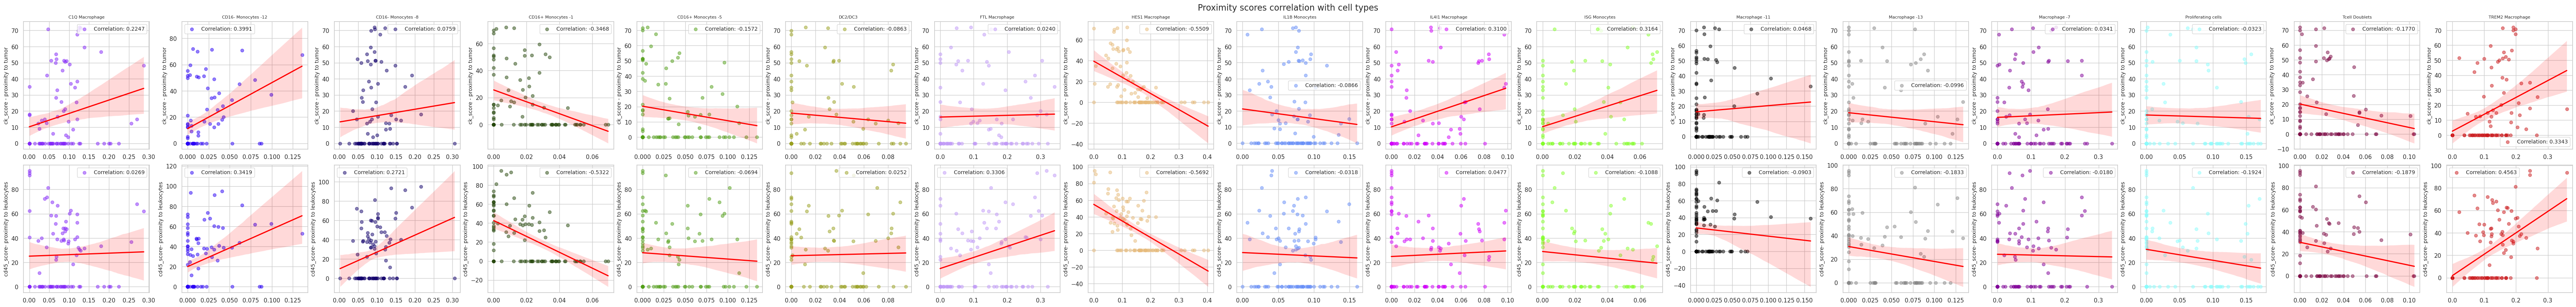

In [16]:
cd68_deconvolution_results['ck_score'] = ck_score
cd68_deconvolution_results['cd45_score'] = cd45_score
# Define the correlations to be plotted
plot_numerical_correlations(df = cd68_deconvolution_results,
                            correlations = macrophage_subtypes,
                            numeric_columns = ['ck_score','cd45_score'],
                            color_dict =  momac_colors,
                            title = "Proximity scores correlation with cell types")
